In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [3]:
START = '2007-01-01'
END = '2022-03-31'

In [4]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID']

In [5]:
stk_info

,secID,ticker,secShortName,cnSpell,exchangeCD,assetClass,listStatusCD,listDate,transCurrCD,ISIN,partyID,delistDate
0,000001.XSHE,000001,平安银行,PAYH,XSHE,E,L,1991-04-03,CNY,CNE000000040,2.0,NaN
1,000002.XSHE,000002,万科A,WKA,XSHE,E,L,1991-01-29,CNY,CNE0000000T2,3.0,NaN
2,000003.XSHE,000003,PT金田A,PTJTA,XSHE,E,DE,1991-07-03,CNY,CNE1000031Y5,4.0,2002-06-14
3,000004.XSHE,000004,国华网安,GHWA,XSHE,E,L,1991-01-14,CNY,CNE0000000Y2,5.0,NaN
4,000005.XSHE,000005,ST星源,STXY,XSHE,E,L,1990-12-10,CNY,CNE0000001L7,6.0,NaN
5,000006.XSHE,000006,深振业A,SZYA,XSHE,E,L,1992-04-27,CNY,CNE000000164,7.0,NaN
6,000007.XSHE,000007,*ST全新,*STQX,XSHE,E,L,1992-04-13,CNY,CNE0000000P0,8.0,NaN
7,000008.XSHE,000008,神州高铁,SZGT,XSHE,E,L,1992-05-07,CNY,CNE0000001C6,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
24126,900950.XSHG,900950,新城B股,XCBG,XSHG,E,DE,1997-10-16,USD,CNE000000TH1,1429.0,2015-11-23


## ST

In [6]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [7]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [8]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

,ym,rf
0,2007-01,0.002100
1,2007-02,0.002110
2,2007-03,0.002234
3,2007-04,0.002125
4,2007-05,0.002527
5,2007-06,0.002542
6,2007-07,0.002481
7,2007-08,0.002404
...,...,...
175,2021-08,0.001941


## Beta

In [9]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

,secID,ym,beta
0,000001.XSHE,2007-01,0.7949
1,000001.XSHE,2007-02,0.7880
2,000001.XSHE,2007-03,0.8512
3,000001.XSHE,2007-04,0.8642
4,000001.XSHE,2007-05,0.7715
5,000001.XSHE,2007-06,0.4614
6,000001.XSHE,2007-07,0.6423
7,000001.XSHE,2007-08,0.7722
...,...,...,...
501234,689009.XSHG,2021-08,1.0727


## Trading data

In [10]:
stk_df = pd.read_pickle('./data/stk_df.pkl')
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)
# Monthly
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()

(9934190, 8)
(9535739, 8)


In [11]:
stk_df_m

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate
0,000001.XSHE,2007-06,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316
1,000001.XSHE,2007-07,2007-07-31,1082.259,1146.498,5.616330e+10,1.479466e+09,0.0270
2,000001.XSHE,2007-08,2007-08-31,1193.016,1202.510,5.890714e+10,6.552881e+08,0.0112
3,000001.XSHE,2007-09,2007-09-28,1228.142,1265.167,6.197651e+10,1.408136e+09,0.0228
4,000001.XSHE,2007-10,2007-10-31,1427.189,1520.542,7.448652e+10,1.440425e+09,0.0200
5,000001.XSHE,2007-11,2007-11-30,1172.447,1141.751,5.593078e+10,5.452159e+08,0.0096
6,000001.XSHE,2007-12,2007-12-28,1234.155,1221.497,6.574629e+10,1.019671e+09,0.0154
7,000001.XSHE,2008-01,2008-01-31,1074.347,1053.778,5.850212e+10,5.328429e+08,0.0089
...,...,...,...,...,...,...,...,...
484445,900957.XSHG,2021-08,2021-08-31,0.626,0.612,1.116880e+08,3.033640e+05,0.0027


## Momentum

Momentum 介绍：

Momentum即动量，指的是过去一段时间表现较好的股票，在未来一段时间内也会较好。“过去”和“未来”有很多定义，比较常见的：
- 过去：t月前的t-12:t-2个月的累积收益率
- 未来: t月的收益

也即，中间跳过了一个月，t-1。
这是因为，短期发现了反转，reversal：上个月表现好的，这个月表现差

Momentum 的计算涉及到pandas groupby rolling。如果是自定义的函数，apply会比较慢。但新版本(pandas version >= 1)中，apply中可以指定用numba作为计算引擎，速度会快非常多。由于优矿的pandas版本很低, 没有这个选项。

另外，按照月来做rolling时，pandas rolling的选项不可以用"MonthEnd"这样长度不固定的时间作为window size。因此，如果想做得很精确的话，需要用一些其他的办法。一种比较容易的思路是把停牌的日期(用MultiIndex)填上，对应的ret值留空。窗口长度就可以固定（通过指定observation个数，而不是月份数）。

- 注意：应当先计算收益率，再填充空值。原因：
    - 如果先填充空值，刚恢复交易时的第一个月，ret会是NaN。若用0填充来得到1+ret==1，会有一定程度的失真。
    - 先计算ret，则刚恢复交易时的第一个月，ret是从刚停牌时的价格和这个月的价格相除计算得到的，较真实。
    
例：

In [12]:
stk_df.loc[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2010-06-20') & (stk_df['tradeDate']<='2010-09-10')]

,secID,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ym
799,000001.XSHE,2010-06-21,714.635,755.071,5.351129e+10,1.063389e+09,0.0202,2010-06
800,000001.XSHE,2010-06-22,755.071,764.561,5.418384e+10,7.704887e+08,0.0143,2010-06
801,000001.XSHE,2010-06-23,764.561,757.134,5.365750e+10,5.972744e+08,0.0111,2010-06
802,000001.XSHE,2010-06-24,757.134,764.561,5.418384e+10,4.329053e+08,0.0080,2010-06
803,000001.XSHE,2010-06-25,764.561,747.231,5.295571e+10,4.151940e+08,0.0078,2010-06
804,000001.XSHE,2010-06-28,747.231,762.910,5.741829e+10,4.487918e+08,0.0079,2010-06
805,000001.XSHE,2010-06-29,762.910,722.475,5.437499e+10,5.491348e+08,0.0099,2010-06
806,000001.XSHE,2010-09-02,722.475,750.532,5.648664e+10,2.984709e+09,0.0526,2010-09
807,000001.XSHE,2010-09-03,750.532,732.790,5.515133e+10,1.110874e+09,0.0201,2010-09
808,000001.XSHE,2010-09-06,732.790,750.945,5.651769e+10,1.106419e+09,0.0196,2010-09


In [13]:
stk_df_m['ret_mom'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret

In [14]:
stk_df_m.sort_values(['secID','ym'],inplace=True)

In [15]:
stk_df_m

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_mom
0,000001.XSHE,2007-06,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,NaN
1,000001.XSHE,2007-07,2007-07-31,1082.259,1146.498,5.616330e+10,1.479466e+09,0.0270,0.316497
2,000001.XSHE,2007-08,2007-08-31,1193.016,1202.510,5.890714e+10,6.552881e+08,0.0112,0.048855
3,000001.XSHE,2007-09,2007-09-28,1228.142,1265.167,6.197651e+10,1.408136e+09,0.0228,0.052105
4,000001.XSHE,2007-10,2007-10-31,1427.189,1520.542,7.448652e+10,1.440425e+09,0.0200,0.201851
5,000001.XSHE,2007-11,2007-11-30,1172.447,1141.751,5.593078e+10,5.452159e+08,0.0096,-0.249116
6,000001.XSHE,2007-12,2007-12-28,1234.155,1221.497,6.574629e+10,1.019671e+09,0.0154,0.069845
7,000001.XSHE,2008-01,2008-01-31,1074.347,1053.778,5.850212e+10,5.328429e+08,0.0089,-0.137306
...,...,...,...,...,...,...,...,...,...
484445,900957.XSHG,2021-08,2021-08-31,0.626,0.612,1.116880e+08,3.033640e+05,0.0027,-0.058462


In [16]:
stk_df_m['1+ret_mom'] = stk_df_m['ret_mom'] + 1

#### Fill na months

In [17]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Parameters:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

In [18]:
%%time
full_dates = np.sort(stk_df['ym'].unique())
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)
stk_df_m.reset_index(drop=True, inplace=True)

CPU times: user 38.4 s, sys: 252 ms, total: 38.6 s
Wall time: 38.6 s


In [19]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna()]

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_mom,1+ret_mom
0,000001.XSHE,2007-06,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,NaN,NaN
37,000001.XSHE,2010-07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,000001.XSHE,2010-08,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,000002.XSHE,2007-01,2007-01-31,701.344,635.360,4.982264e+10,1.400388e+09,0.0269,NaN,NaN
286,000002.XSHE,2016-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
287,000002.XSHE,2016-02,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,000002.XSHE,2016-03,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289,000002.XSHE,2016-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
507059,900955.XSHG,2015-07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
stk_df_m.loc[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['ym']>='2010-06') & (stk_df_m['ym']<='2010-11')]

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_mom,1+ret_mom
36,000001.XSHE,2010-06,2010-06-29,762.910,722.475,5.437499e+10,549134850.0,0.0099,0.000000,1.000000
37,000001.XSHE,2010-07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,000001.XSHE,2010-08,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,000001.XSHE,2010-09,2010-09-29,670.899,669.249,5.036906e+10,347260768.0,0.0069,-0.073672,0.926328
40,000001.XSHE,2010-10,2010-10-29,774.463,759.610,5.716982e+10,663509380.0,0.0115,0.135019,1.135019
41,000001.XSHE,2010-11,2010-11-30,689.879,676.263,5.089697e+10,464292192.0,0.0091,-0.109723,0.890277


In [20]:
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。

In [21]:
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 
stk_df_m['mom_6m'] = stk_df_m.groupby('secID').rolling(6,min_periods=6)['1+ret_mom'].apply(np.prod, raw=True).values - 1 
# 当只用numpy function时可以选raw=True，只用ndarray格式的数据，运算速度快很多。

In [22]:
stk_df_m

,secID,ym,tradeDate,preClosePrice,closePrice,negMarketValue,turnoverValue,turnoverRate,ret_mom,1+ret_mom,mom,mom_6m
0,000001.XSHE,2007-06,2007-06-29,953.780,870.870,4.266117e+10,1.410758e+09,0.0316,NaN,1.000000,NaN,NaN
1,000001.XSHE,2007-07,2007-07-31,1082.259,1146.498,5.616330e+10,1.479466e+09,0.0270,0.316497,1.316497,NaN,NaN
2,000001.XSHE,2007-08,2007-08-31,1193.016,1202.510,5.890714e+10,6.552881e+08,0.0112,0.048855,1.048855,NaN,NaN
3,000001.XSHE,2007-09,2007-09-28,1228.142,1265.167,6.197651e+10,1.408136e+09,0.0228,0.052105,1.052105,NaN,NaN
4,000001.XSHE,2007-10,2007-10-31,1427.189,1520.542,7.448652e+10,1.440425e+09,0.0200,0.201851,1.201851,NaN,NaN
5,000001.XSHE,2007-11,2007-11-30,1172.447,1141.751,5.593078e+10,5.452159e+08,0.0096,-0.249116,0.750884,NaN,0.311046
6,000001.XSHE,2007-12,2007-12-28,1234.155,1221.497,6.574629e+10,1.019671e+09,0.0154,0.069845,1.069845,NaN,0.402617
7,000001.XSHE,2008-01,2008-01-31,1074.347,1053.778,5.850212e+10,5.328429e+08,0.0089,-0.137306,0.862694,NaN,-0.080872
...,...,...,...,...,...,...,...,...,...,...,...,...
507459,900957.XSHG,2021-08,2021-08-31,0.626,0.612,1.116880e+08,3.033640e+05,0.0027,-0.058462,0.941538,0.186047,-0.170732


In [23]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [24]:
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['tradeDate','closePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']

In [25]:
# 把日期对齐。
# 例：
# ret_date == 2020.03
# size_date == 2020.02
# cumret_date == 2020.01
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_6m'] = stk_df_m.groupby(['secID'])['mom_6m'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [26]:
stk_df_m.dropna(inplace=True)

In [27]:
stk_df_m = stk_df_m[['secID','ret_date','exret','mom_date','mom','mom_6m','ym','negMarketValue','size']]

In [28]:
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)

In [29]:
stk_df_m.sort_values(['secID','ym'],inplace=True)

In [31]:
stk_df_m

,secID,ret_date,exret,mom_date,mom,mom_6m,ym,mktcap,size
16100,000001.XSHE,2008-06,-0.236961,2008-04,0.076309,-0.383559,2008-05,4.432458e+10,24.514805
17658,000001.XSHE,2008-07,0.073241,2008-05,-0.083212,-0.300721,2008-06,4.140495e+10,24.446666
19238,000001.XSHE,2008-08,-0.031527,2008-06,-0.466464,-0.499223,2008-07,4.455369e+10,24.519961
20825,000001.XSHE,2008-09,-0.260811,2008-07,-0.452632,-0.375375,2008-08,4.326849e+10,24.490690
22418,000001.XSHE,2008-10,-0.274468,2008-08,-0.494747,-0.390649,2008-09,3.210865e+10,24.192391
24017,000001.XSHE,2008-11,0.072172,2008-09,-0.688034,-0.468440,2008-10,2.330715e+10,23.872026
25616,000001.XSHE,2008-12,0.051257,2008-10,-0.697524,-0.631556,2008-11,2.503361e+10,23.943485
27216,000001.XSHE,2009-01,0.229523,2008-11,-0.696328,-0.535405,2008-12,2.634237e+10,23.994445
...,...,...,...,...,...,...,...,...,...
464995,900957.XSHG,2021-08,-0.060402,2021-06,0.094178,0.260355,2021-07,1.186800e+08,18.591941


## BM

In [32]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

,secID,ym,bm
0,000001.XSHE,2007-01,0.162639
1,000001.XSHE,2007-02,0.163321
2,000001.XSHE,2007-03,0.176236
3,000001.XSHE,2007-04,0.140732
4,000001.XSHE,2007-05,0.127291
5,000001.XSHE,2007-06,0.123739
6,000001.XSHE,2007-07,0.093992
7,000001.XSHE,2007-08,0.097085
...,...,...,...
500888,689009.XSHG,2021-08,0.076097


## Merge 

In [33]:
stk_df_m

,secID,ret_date,exret,mom_date,mom,mom_6m,ym,mktcap,size
16100,000001.XSHE,2008-06,-0.236961,2008-04,0.076309,-0.383559,2008-05,4.432458e+10,24.514805
17658,000001.XSHE,2008-07,0.073241,2008-05,-0.083212,-0.300721,2008-06,4.140495e+10,24.446666
19238,000001.XSHE,2008-08,-0.031527,2008-06,-0.466464,-0.499223,2008-07,4.455369e+10,24.519961
20825,000001.XSHE,2008-09,-0.260811,2008-07,-0.452632,-0.375375,2008-08,4.326849e+10,24.490690
22418,000001.XSHE,2008-10,-0.274468,2008-08,-0.494747,-0.390649,2008-09,3.210865e+10,24.192391
24017,000001.XSHE,2008-11,0.072172,2008-09,-0.688034,-0.468440,2008-10,2.330715e+10,23.872026
25616,000001.XSHE,2008-12,0.051257,2008-10,-0.697524,-0.631556,2008-11,2.503361e+10,23.943485
27216,000001.XSHE,2009-01,0.229523,2008-11,-0.696328,-0.535405,2008-12,2.634237e+10,23.994445
...,...,...,...,...,...,...,...,...,...
464995,900957.XSHG,2021-08,-0.060402,2021-06,0.094178,0.260355,2021-07,1.186800e+08,18.591941


In [34]:
beta_df_m

,secID,ym,beta
0,000001.XSHE,2007-01,0.7949
1,000001.XSHE,2007-02,0.7880
2,000001.XSHE,2007-03,0.8512
3,000001.XSHE,2007-04,0.8642
4,000001.XSHE,2007-05,0.7715
5,000001.XSHE,2007-06,0.4614
6,000001.XSHE,2007-07,0.6423
7,000001.XSHE,2007-08,0.7722
...,...,...,...
501234,689009.XSHG,2021-08,1.0727


In [35]:
ret_df = pd.merge(stk_df_m, beta_df_m, on=['secID','ym'],how='left') # beta 的 na 值不管它，不是重点，保留左边的dataframe

In [36]:
ret_df = pd.merge(ret_df, pb_df,on=['secID','ym'] ,how='left')

In [37]:
ret_df

,secID,ret_date,exret,mom_date,mom,mom_6m,ym,mktcap,size,beta,bm
0,000001.XSHE,2008-06,-0.236961,2008-04,0.076309,-0.383559,2008-05,4.432458e+10,24.514805,1.0697,0.242665
1,000001.XSHE,2008-07,0.073241,2008-05,-0.083212,-0.300721,2008-06,4.140495e+10,24.446666,1.0672,0.304090
2,000001.XSHE,2008-08,-0.031527,2008-06,-0.466464,-0.499223,2008-07,4.455369e+10,24.519961,1.0966,0.282598
3,000001.XSHE,2008-09,-0.260811,2008-07,-0.452632,-0.375375,2008-08,4.326849e+10,24.490690,1.0386,0.351136
4,000001.XSHE,2008-10,-0.274468,2008-08,-0.494747,-0.390649,2008-09,3.210865e+10,24.192391,1.1184,0.473171
5,000001.XSHE,2008-11,0.072172,2008-09,-0.688034,-0.468440,2008-10,2.330715e+10,23.872026,1.1991,0.706914
6,000001.XSHE,2008-12,0.051257,2008-10,-0.697524,-0.631556,2008-11,2.503361e+10,23.943485,1.2192,0.658155
7,000001.XSHE,2009-01,0.229523,2008-11,-0.696328,-0.535405,2008-12,2.634237e+10,23.994445,1.2206,0.625469
...,...,...,...,...,...,...,...,...,...,...,...
421405,900957.XSHG,2021-08,-0.060402,2021-06,0.094178,0.260355,2021-07,1.186800e+08,18.591941,NaN,NaN


In [39]:
# ret_df_full = ret_df.copy()
# ret_df = ret_df[ret_df['ret_date']>='2015'].copy()
# ret_df = ret_df_full.copy()

# Momentum single sort

In [40]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['mom_date'])['mom'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='mom_date')

In [41]:
ret_df_q

,secID,ret_date,exret,mom_date,mom,mom_6m,ym,mktcap,size,beta,bm,q1,q2,q3,q4,q5,q6,q7,q8,q9
0,000001.XSHE,2008-06,-0.236961,2008-04,0.076309,-0.383559,2008-05,4.432458e+10,24.514805,1.0697,0.242665,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
1,000002.XSHE,2008-06,-0.268738,2008-04,0.255538,-0.374005,2008-05,1.161977e+11,25.478559,1.0158,0.222539,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
2,000006.XSHE,2008-06,-0.337022,2008-04,0.031918,-0.265639,2008-05,5.347648e+09,22.399923,1.1668,0.333045,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
3,000012.XSHE,2008-06,-0.206991,2008-04,0.352915,-0.118953,2008-05,8.225671e+09,22.830526,1.0991,0.188466,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
4,000014.XSHE,2008-06,-0.187098,2008-04,0.012457,-0.255964,2008-05,1.813492e+09,21.318520,0.8748,0.133397,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
5,000016.XSHE,2008-06,-0.304137,2008-04,0.190728,0.449217,2008-05,3.218501e+09,21.892182,0.9041,0.552456,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
6,000019.XSHE,2008-06,-0.232837,2008-04,0.296517,-0.309505,2008-05,1.011833e+09,20.735029,0.8915,0.127740,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
7,000021.XSHE,2008-06,-0.316820,2008-04,-0.333955,-0.381665,2008-05,3.763882e+09,22.048717,1.0652,0.396369,-0.408563,-0.349779,-0.297711,-0.236348,-0.171563,-0.095482,0.017787,0.167864,0.425902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421405,900949.XSHG,2010-10,0.060035,2010-08,0.135945,-0.111712,2010-09,4.008900e+08,19.809198,NaN,NaN,-0.108775,0.007964,0.113860,0.189855,0.294792,0.399063,0.519969,0.675807,0.958518


In [42]:
portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['mom'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['mom']) & (ret_df_q['mom'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['mom'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.004772,0.007278,0.007742,0.008323,0.009849,0.009165,0.007817,0.007099,0.005409,0.004262,-0.000509
t-value,0.592740,0.933127,1.003744,1.110797,1.307999,1.239649,1.029116,0.935658,0.730228,0.589883,-0.118755


# Sort on size and mom

In [43]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_mom = dict()
keys = ['q_mom_1','q_mom_2']
values = [0.3, 0.7]
q_mom.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['ym'])['size'].quantile(value)

q_mom_df = pd.DataFrame()
for key, value in q_mom.items():
    q_mom_df[key] = ret_df.groupby(['mom_date'])['mom'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='ym')
ret_df_q = pd.merge(ret_df_q, q_mom_df, on='mom_date')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]

portfolios_mom = dict()
portfolios_mom['mom1'] = ret_df_q.loc[ret_df_q['mom'] <= ret_df_q['q_mom_1'],
                                           ['secID','ym','ret_date','exret','mom']]
portfolios_mom['mom2'] = ret_df_q.loc[(ret_df_q['mom'] >= ret_df_q['q_mom_1']) & \
                                           (ret_df_q['mom'] <= ret_df_q['q_mom_2']),
                                           ['secID','ym','ret_date','exret','mom']]
portfolios_mom['mom3'] = ret_df_q.loc[ret_df_q['mom'] >= ret_df_q['q_mom_2'],
                                           ['secID','ym','ret_date','exret','mom']]

portfolios = dict()
for mom_group in portfolios_mom.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{mom_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_mom[mom_group][['secID','ret_date','mom']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有mom和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['mom1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(171,)
(171,)
(171,)
(171,)
(171,)
(171,)


,mom1_size1,mom1_size2,mom2_size1,mom2_size2,mom3_size1,mom3_size2
ret_mean,0.011266,0.000735,0.013341,0.003174,0.009151,0.002499
t_values,1.428915,0.094298,1.703624,0.445135,1.133661,0.352932


# Fama MacBeth regression

In [44]:
ret_df['exret100'] = ret_df['exret'] * 100

def fm_reg(df,cols):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return [None]*(len(cols)+1)
    reg = LinearRegression(fit_intercept=True).fit(y=df_.loc[:,'exret100'], X=df_.loc[:,cols])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [45]:
cols = ['size']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,size
ret_mean,11.119108,-0.471948
t_values,2.911662,-2.981927


In [46]:
cols = ['beta','size','bm','mom']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom
ret_mean,12.151013,-0.011070,-0.536865,1.109133,-0.018742
t_values,3.268864,-0.028461,-3.518452,2.390261,-0.072048


# Reversal

In [47]:
ret_df['rev'] = ret_df.groupby('secID')['exret'].shift()

In [48]:
ret_df

,secID,ret_date,exret,mom_date,mom,mom_6m,ym,mktcap,size,beta,bm,exret100,rev
0,000001.XSHE,2008-06,-0.236961,2008-04,0.076309,-0.383559,2008-05,4.432458e+10,24.514805,1.0697,0.242665,-23.696074,NaN
1,000001.XSHE,2008-07,0.073241,2008-05,-0.083212,-0.300721,2008-06,4.140495e+10,24.446666,1.0672,0.304090,7.324091,-0.236961
2,000001.XSHE,2008-08,-0.031527,2008-06,-0.466464,-0.499223,2008-07,4.455369e+10,24.519961,1.0966,0.282598,-3.152674,0.073241
3,000001.XSHE,2008-09,-0.260811,2008-07,-0.452632,-0.375375,2008-08,4.326849e+10,24.490690,1.0386,0.351136,-26.081082,-0.031527
4,000001.XSHE,2008-10,-0.274468,2008-08,-0.494747,-0.390649,2008-09,3.210865e+10,24.192391,1.1184,0.473171,-27.446815,-0.260811
5,000001.XSHE,2008-11,0.072172,2008-09,-0.688034,-0.468440,2008-10,2.330715e+10,23.872026,1.1991,0.706914,7.217240,-0.274468
6,000001.XSHE,2008-12,0.051257,2008-10,-0.697524,-0.631556,2008-11,2.503361e+10,23.943485,1.2192,0.658155,5.125734,0.072172
7,000001.XSHE,2009-01,0.229523,2008-11,-0.696328,-0.535405,2008-12,2.634237e+10,23.994445,1.2206,0.625469,22.952333,0.051257
...,...,...,...,...,...,...,...,...,...,...,...,...,...
421405,900957.XSHG,2021-08,-0.060402,2021-06,0.094178,0.260355,2021-07,1.186800e+08,18.591941,NaN,NaN,-6.040237,0.015272


# Reversal single sort

In [49]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['ym'])['rev'].quantile(value)

ret_df_q = pd.merge(ret_df, quantile_df, on='ym')

portfolios = dict()
drop_cols = [col for col in ret_df_q.columns if col[0]=='q']

portfolios['p1'] = ret_df_q.loc[ret_df_q['rev'] <= ret_df_q['q1']].copy().drop(drop_cols, axis=1)
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['rev']) & (ret_df_q['rev'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx].copy().drop(drop_cols, axis=1)
portfolios['p10'] = ret_df_q.loc[ret_df_q['rev'] >= ret_df_q['q9']].copy().drop(drop_cols, axis=1)

portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_date'])['exret'].mean()

mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p10-p1
mean,0.011153,0.011873,0.011540,0.010214,0.010323,0.011393,0.008036,0.006406,0.001786,-0.004663,-0.015816
t-value,1.470520,1.579928,1.555409,1.333802,1.357102,1.525834,1.058328,0.883204,0.237767,-0.613183,-3.962279


# Double Sorting on Size and Reversal

In [50]:
q_size = dict()
keys = ['q_size_1']
values = [0.5]
q_size.update(zip(keys,values))

q_rev = dict()
keys = ['q_rev_1','q_rev_2']
values = [0.3, 0.7]
q_rev.update(zip(keys,values))

q_size_df = pd.DataFrame()
for key, value in q_size.items():
    q_size_df[key] = ret_df.groupby(['ym'])['size'].quantile(value)

q_rev_df = pd.DataFrame()
for key, value in q_rev.items():
    q_rev_df[key] = ret_df.groupby(['ym'])['rev'].quantile(value)

ret_df_q = pd.merge(ret_df, q_size_df, on='ym')
ret_df_q = pd.merge(ret_df_q, q_rev_df, on='ym')

portfolios_size = dict()
portfolios_size['size1'] = ret_df_q.loc[ret_df_q['size'] <= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]
portfolios_size['size2'] = ret_df_q.loc[ret_df_q['size'] >= ret_df_q['q_size_1'],
                                           ['secID','ym','ret_date','exret','size','mktcap']]

portfolios_rev = dict()
portfolios_rev['rev1'] = ret_df_q.loc[ret_df_q['rev'] <= ret_df_q['q_rev_1'],
                                           ['secID','ym','ret_date','exret','rev']]
portfolios_rev['rev2'] = ret_df_q.loc[(ret_df_q['rev'] >= ret_df_q['q_rev_1']) & \
                                           (ret_df_q['rev'] <= ret_df_q['q_rev_2']),
                                           ['secID','ym','ret_date','exret','rev']]
portfolios_rev['rev3'] = ret_df_q.loc[ret_df_q['rev'] >= ret_df_q['q_rev_2'],
                                           ['secID','ym','ret_date','exret','rev']]

portfolios = dict()
for rev_group in portfolios_rev.keys():
    for size_group in portfolios_size.keys():
        portfolios[f'{rev_group}_{size_group}'] = pd.merge(portfolios_size[size_group],
                                                              portfolios_rev[rev_group][['secID','ret_date','rev']],
                                                              on=['secID','ret_date'])

mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_date')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上没有rev和size分组没有任何交叉

# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['rev1_size1'].index

# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

(170,)
(170,)
(170,)
(170,)
(170,)
(170,)


,rev1_size1,rev1_size2,rev2_size1,rev2_size2,rev3_size1,rev3_size2
ret_mean,0.01674,0.006765,0.014695,0.004649,0.003711,-0.001491
t_values,2.11981,0.912580,1.863767,0.629931,0.470534,-0.205014


## FM regression on Reversal

In [51]:
cols = ['beta','size','bm','mom','rev']
temp = ret_df.groupby('ret_date').apply(fm_reg, cols=cols)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept'] + cols
reg_result_df.dropna(inplace=True)
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

,intercept,beta,size,bm,mom,rev
ret_mean,11.807590,-0.156102,-0.512645,0.723984,-0.142003,-4.558951
t_values,3.055111,-0.389382,-3.278263,1.626673,-0.459694,-5.587708


# Reversal factor

In [52]:
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_date')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_date')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_exret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret['rev1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()
portfolios_vwret_df.rename(columns={"rev1_size1": "Small_LowRet",
                                    "rev2_size1": "Small_MedRet",
                                    "rev3_size1": "Small_HighRet",
                                    "rev1_size2": "Big_LowRet",
                                    "rev2_size2": "Big_MedRet",
                                    "rev3_size2": "Big_HighRet"},
                          inplace=True)

In [53]:
portfolios_vwret_df

,Small_LowRet,Big_LowRet,Small_MedRet,Big_MedRet,Small_HighRet,Big_HighRet
ret_date,,,,,,
2008-02,0.094665,0.024558,0.108872,0.023869,0.115705,0.030757
2008-03,-0.192331,-0.163018,-0.178676,-0.224631,-0.183230,-0.216635
2008-04,-0.023034,0.075035,-0.068248,0.055380,-0.100413,-0.018084
2008-05,0.001173,-0.078373,-0.023021,-0.066636,-0.041251,-0.095612
2008-06,-0.265260,-0.233824,-0.248027,-0.225978,-0.262296,-0.217338
2008-07,0.130534,0.038327,0.110268,0.041078,0.064990,-0.003460
2008-08,-0.234575,-0.176245,-0.217874,-0.150069,-0.224829,-0.195775
2008-09,-0.077498,-0.049067,-0.078070,-0.031726,-0.111573,-0.092973
...,...,...,...,...,...,...


In [54]:
rev_df = (portfolios_vwret_df['Small_LowRet'] + portfolios_vwret_df['Big_LowRet']) / 2 - \
       (portfolios_vwret_df['Small_HighRet'] + portfolios_vwret_df['Big_HighRet']) / 2 

In [55]:
rev_df = rev_df.reset_index()
rev_df.columns = ['ret_date','rev']
rev_df

,ret_date,rev
0,2008-02,-0.013619
1,2008-03,0.022258
2,2008-04,0.085249
3,2008-05,0.029831
4,2008-06,-0.009725
5,2008-07,0.053666
6,2008-08,0.004892
7,2008-09,0.038991
...,...,...
162,2021-08,-0.053472


## Combine with FF3

In [56]:
factors_df = pd.read_csv('./data/factors/ff3.csv')

In [57]:
factors_df

,ret_date,exmktret,SMB,HML
0,2007-05-31,0.098693,-0.031591,-0.021360
1,2007-06-30,-0.074622,-0.117856,-0.000611
2,2007-07-31,0.192240,0.071317,0.021021
3,2007-08-31,0.167193,-0.065446,0.030286
4,2007-09-30,0.047263,-0.020948,0.048817
5,2007-10-31,-0.010382,-0.110560,0.005402
6,2007-11-30,-0.157389,0.113938,0.017011
7,2007-12-31,0.137366,0.065398,-0.022715
...,...,...,...,...
170,2021-07-31,-0.064776,0.043955,-0.032335


In [58]:
factors_df['ret_date'] = pd.to_datetime(factors_df['ret_date']) 

factors_df['ret_date'] = factors_df['ret_date'].dt.to_period('M')

factors_df = pd.merge(factors_df, rev_df, on='ret_date')

factors_df['ret_date'] = factors_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_df.set_index('ret_date',inplace=True)

In [59]:
factors_df

,exmktret,SMB,HML,rev
ret_date,,,,
2008-02-29,0.024010,0.084902,0.007286,-0.013619
2008-03-31,-0.195480,0.013640,-0.022060,0.022258
2008-04-30,0.022519,-0.118534,0.024671,0.085249
2008-05-31,-0.080798,0.063246,-0.001105,0.029831
2008-06-30,-0.236014,-0.029915,-0.003586,-0.009725
2008-07-31,0.014972,0.090890,0.008773,0.053666
2008-08-31,-0.170063,-0.066046,0.032837,0.004892
2008-09-30,-0.067913,-0.033079,0.032129,0.038991
...,...,...,...,...


In [60]:
factors_df.to_csv('./data/factors/ff3_rev.csv')

In [61]:
factors_df.to_pickle('./data/factors/ff3_rev.pkl')

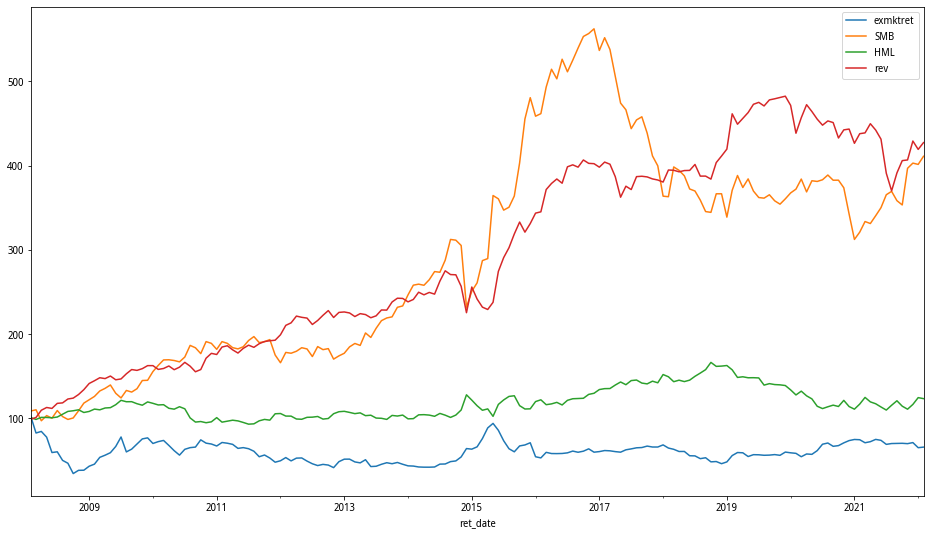

In [62]:
((1 + factors_df).cumprod()*100).plot()

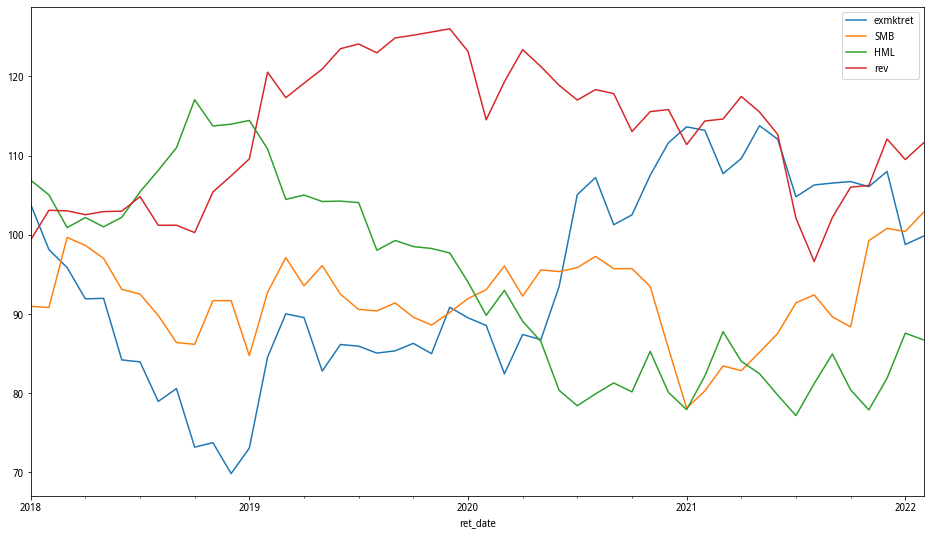

In [63]:
((1 + factors_df['2018':]).cumprod()*100).plot()

## Long-only factor

In [64]:
rev_long_df = (portfolios_vwret_df['Small_LowRet'] + portfolios_vwret_df['Big_LowRet']) / 2

rev_long_df = rev_long_df.reset_index()

rev_long_df.columns=['ret_date','rev_long']

rev_long_df

,ret_date,rev_long
0,2008-02,0.059612
1,2008-03,-0.177674
2,2008-04,0.026001
3,2008-05,-0.038600
4,2008-06,-0.249542
5,2008-07,0.084431
6,2008-08,-0.205410
7,2008-09,-0.063282
...,...,...
162,2021-08,0.019832


In [65]:
factors_long_df = pd.read_csv('./data/factors/ff3_long_only.csv')

factors_long_df['ret_date'] = pd.to_datetime(factors_long_df['ret_date']) 

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_period('M')

factors_long_df = pd.merge(factors_long_df, rev_long_df, on='ret_date')

factors_long_df['ret_date'] = factors_long_df['ret_date'].dt.to_timestamp(freq='day',how='end').dt.normalize()

factors_long_df.set_index('ret_date',inplace=True)

In [66]:
factors_long_df

,exmktret,small_only,high_only,rev_long
ret_date,,,,
2008-02-29,0.024010,0.106350,0.060789,0.059612
2008-03-31,-0.195480,-0.185605,-0.204875,-0.177674
2008-04-30,0.022519,-0.073984,-0.008138,0.026001
2008-05-31,-0.080798,-0.020726,-0.056888,-0.038600
2008-06-30,-0.236014,-0.258596,-0.240880,-0.249542
2008-07-31,0.014972,0.110389,0.072120,0.084431
2008-08-31,-0.170063,-0.234635,-0.187086,-0.205410
2008-09-30,-0.067913,-0.088250,-0.068698,-0.063282
...,...,...,...,...


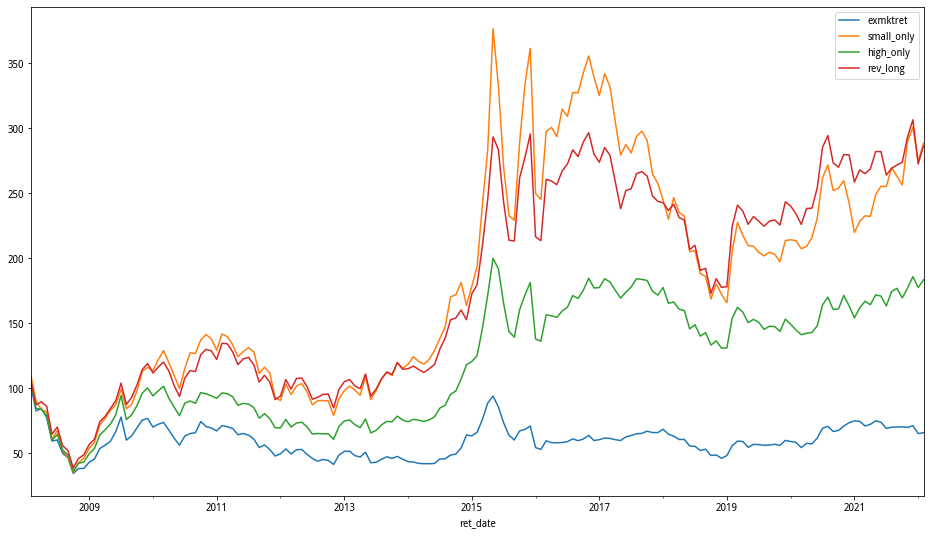

In [67]:
((1 + factors_long_df).cumprod()*100).plot()

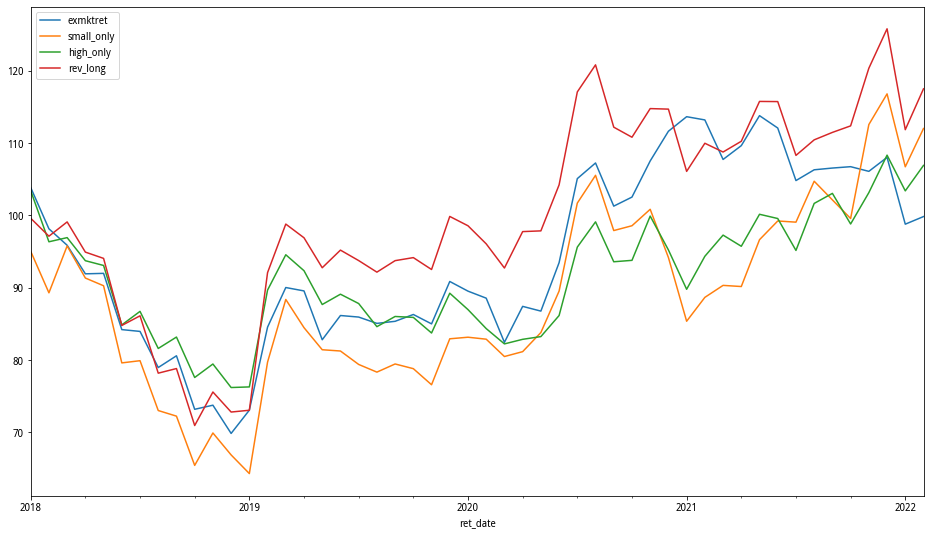

In [68]:
((1 + factors_long_df['2018':]).cumprod()*100).plot()

In [69]:
factors_long_df.to_csv('./data/factors/ff3_rev_long_only.csv')

In [70]:
factors_long_df.to_pickle('./data/factors/ff3_rev_long_only.pkl')